# Wavelet transformations
As we have seen for time dependent signals, we need to use a short time Fourier transform to capture time dependency. However, if we use a small window (good temporal resolution), it limits the accuracy in the frequency domain of FFT, i.e. one cannot capture high frequencies. The opposite is also true, if we capture temporal variation poorly, the frequency resolution is good.

Thus, we want to represent our signal as something different than sines or cosines, namely _wavelets_. We will use the same signal as for the STFT tutorial.

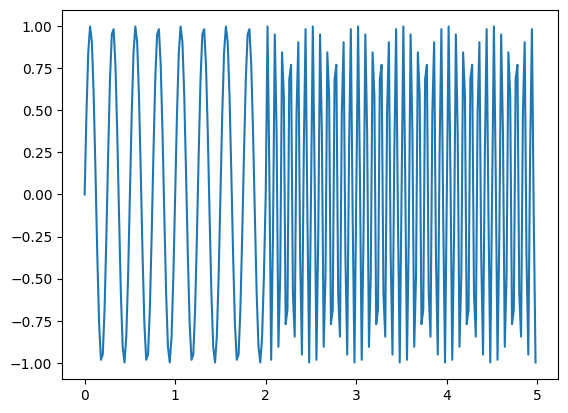

In [7]:
import numpy as np
import matplotlib.pyplot as plt
T = 5
sample_frequency = 50
t = np.linspace(0,T, int(sample_frequency*T), endpoint=False)

def x(t, time_varying:bool=True, T_s:float=2):
    if time_varying:
        return (t<T_s)*np.sin(8*np.pi*t) + (t>T_s)*np.sin(24*np.pi*t)
    else:
        return np.sin(8*np.pi*t) + np.sin(24*np.pi*t)
signal = x(t, True)
_ = plt.plot(t, signal)

We will use the library called [PyWavelets](https://github.com/PyWavelets/pywt) to compute the continuous and discrete wavelet transform (CWT and DWT). The Ozturk paper used the CWT of the signal with the Morlet wavelet. The CWT function takes in three arguments, the signal, a set of scales and the wavelet we want to use. The scales determine the stretching factor of a given wavelet.

The wavelet transform is computed by the following formula:
$$
F(\tau, s) = \frac{1}{\sqrt{\vert s \vert}}\int_{-\infty}^{\infty}f(t)\psi^*\left(\frac{t-\tau}{s}\right)~\mathrm{d}s
$$
where $s=\frac{1}{\text{frequency}}$ and $\psi^*$ is the complex conjugate of the wavelet function $\psi$.
This means that we want to represent the signal as a combination of the wavelets, i.e. they are our basis functions. A large value of $s$ gives a large window, resolving low frequencies, while a small value of $s$ resolves high frequencies. 

In [8]:
import pywt
from ipywidgets import interact, widgets

ws = {'description_width': 'initial'}
c_waves = pywt.wavelist(None,kind="continuous")

@interact(wavelet=widgets.Dropdown(options=c_waves, value="morl",
                                description='Wavelet',
                                disabled=False, style=ws),
)
def compute_cwt(wavelet:str):
    wl = pywt.ContinuousWavelet(wavelet)
    wavelet_function, x_values = wl.wavefun()
    plt.subplot(211)
    plt.plot(x_values, wavelet_function)
    frequencies = np.arange(1, sample_frequency) / sample_frequency # normalize
    scales = pywt.frequency2scale(wl, frequencies)
    [cfs, frequencies] = pywt.cwt(signal, scales, wl, sampling_period=T)
    period = 1. / frequencies
    plt.subplot(212)
    plt.contourf(t, period, abs(cfs), extend='both')


interactive(children=(Dropdown(description='Wavelet', index=19, options=('cgau1', 'cgau2', 'cgau3', 'cgau4', '…

# Discrete Wavelet Transform is defined as follows
$$
\begin{align}
D[\tau, s]=D[k2^{-j}, 2^{-j}]=\frac{1}{\sqrt{s}}\sum_{m=0}^{p-1}x(t_m)\psi\left(\frac{t_m-\tau}{s}\right)
\end{align}
$$
However, the wavelet transform is computed by passing the signal through a series of filters.
The signal is passed through a high-pass filter (ignore low frequencies) and a low-pass (ignoring high frequencies). 
The _approximation coefficients_ are defined as the result of the low-pass filtering.
The _detail coefficients_ are defined as the result of the high-pass filtering.
Decomposing the signal into a low-pass part and high-pass part, you are splitting the frequency content into two sub-sets. You can keep on decomposing these sets into smaller and smaller parts of the frequency spectrum.

It is often used in signal compressing and denoising.

In [9]:
d_waves = pywt.wavelist(None,kind="discrete")
@interact(wave=widgets.Dropdown(options=d_waves, value=d_waves[-1],
                                description='Wavelet',
                                disabled=False, style=ws),
         ref= widgets.IntSlider(5, min=1, max=10, description="Refinement level",style=ws),
)
def compute_dwt(wave:str, ref:int):
    plt.figure()
    plt.subplot(211)
    wavelet = pywt.Wavelet(wave)
    try:
        if wavelet.biorthogonal and not wavelet.orthogonal:
            (phi_d, psi_d, phi_r, psi_r, x) = wavelet.wavefun(level=ref)
            plt.plot(x, psi_d, label="Decomposition wavelet")
            plt.plot(x, psi_r, label="Reconstruction wavelet")
            plt.legend()
        else:
            (phi, psi, x) = wavelet.wavefun(level=ref)
            plt.plot(x, psi)
        plt.grid()
        plt.title(f"Wavelet {wave}")
    except ValueError as e:
        print(e)
    plt.subplot(212)
    cA, cD = pywt.dwt(signal, wavelet)
    plt.plot(cA, label="Approximation Coefficient")
    plt.plot(cD, label="Detail Coefficient")
    plt.grid()
    plt.legend()

interactive(children=(Dropdown(description='Wavelet', index=105, options=('bior1.1', 'bior1.3', 'bior1.5', 'bi…